In [2]:
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Functions

In [171]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    positions = [0]
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(1, len(df)):
        if i == len(df) - 1 and current_pos == 0:
            pass
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
        elif current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1, 'spread': df.iloc[i]})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1, 'spread': df.iloc[i]})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        
        positions.append(current_pos)
    
    return (pd.DataFrame(trades), positions)


def filter_universe_graphical_lasso(prices_df, penalty=0.1, display=False):
    # implementation from https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7
    returns = prices_df.pct_change()[1:]

    edge_model = covariance.GraphicalLassoCV()
    returns /= returns.std(axis=0)
    edge_model.fit(returns)
    p = edge_model.precision_

    #prepare the matrix for network illustration
    p = pd.DataFrame(p, columns=prices_df.columns, index=prices_df.columns)
    links = p.stack().reset_index()
    links.columns = ['var1', 'var2','value']
    links=links.loc[ (abs(links['value']) > penalty) &  (links['var1'] != links['var2']) ]

    #build the graph using networkx lib
    G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

    if display:
        plt.figure(3, figsize=(10, 10))
        nx.draw(G, pos=pos)
        nx.draw_networkx_labels(G, pos=pos)
        plt.show()
    
    return G


def get_best_pair_candidates(graph, formation_prices_df, nbr_of_candidates=10):
    # Find most mean reverting pairs
    ridge = RidgeCV()
    unique_pairs = []
    possible_pairs = []
    clusters = nx.connected_components(graph)
    
    for cluster in clusters:
        perps = list(cluster)
        for perp_a in perps:
            for perp_b in perps:
                pair = '{}/{}'.format(perp_a, perp_b)
                if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                    
                    # regress prices
                    ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))

                    # test for mean-reversion
                    spread =  formation_prices_df[perp_b] - ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                    half_life = calculat_half_life(spread)
                    adf = adfuller(spread, 1)
                    hurst = calculate_hurst(spread)

                    # calculate positions ratio in dollars
                    total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                    size_ratio = formation_prices_df[perp_b] / total_size

                    possible_pairs.append({
                        'pair': pair,
                        'perp_a': perp_a,
                        'perp_b': perp_b,
                        'beta_units': ridge_reg.coef_[0][0],
                        'half_life': half_life,
                        'adf_pvalue': adf[1],
                        'hurst': hurst,
                        'long_short_position_ratio': size_ratio.mean()
                    })

                    unique_pairs.append(pair)

    possible_pairs = pd.DataFrame(possible_pairs)
    top_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['half_life'])[:nbr_of_candidates]
    
    return top_pairs


# params = {start_date, end_date, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs, display_cluster}
def backtest_mean_reversion_portfolio(prices_df, params, display=False):
    
    # Narrow down universe
    formation_start_date = params['start_date']
    formation_end_date = formation_start_date + timedelta(days=params['formation_period_days'])
    formation_prices_df = prices_df[formation_start_date:formation_end_date].T.dropna().T
    graph = filter_universe_graphical_lasso(formation_prices_df, 0.1, params['display_cluster'])

    # Rank and select top pairs based on mean reversion properies
    top_pairs = get_best_pair_candidates(graph, formation_prices_df, params['nbr_max_pairs'])

    # Backtest
    taker_fee = params['taker_fee']
    std_entry_multiple = params['entry_multiple']
    std_stop_multiple = params['stop_multiple']
    half_life_multiple = params['half_life_multiple']

    trading_start_date = formation_end_date
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].T.dropna().T

    individual_pairs_data = {}
    individual_trades_data = []
    portfolio_cumret = None
    for i in range(0, len(top_pairs)):

        row = top_pairs.iloc[i]

        # trades
        trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
        position_size = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]).sum(axis=1))
        rolling_mean = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.mean)
        rolling_std = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.std)
        rolling_entry = std_entry_multiple * rolling_std
        rolling_stop = std_stop_multiple * rolling_std

        trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

        # save trade data for stats
        for i in range(0, len(trades)):
            if trades.iloc[i]['position'] != 0:
                unit_position_size = position_size.loc[trades.iloc[i]['date']]
                fee = unit_position_size * taker_fee
                pnl = (trading_spread.loc[trades.iloc[i + 1]['date']] - trading_spread.loc[trades.iloc[i]['date']]) * trades.iloc[i]['position']
                pnl_after_fee = pnl - fee
                ret = pnl_after_fee / trading_spread.loc[trades.iloc[i]['date']]
                individual_trades_data.append({
                    'pair': row['pair'],
                    'date_open': trades.iloc[i]['date'],
                    'date_close': trades.iloc[i + 1]['date'],
                    'position': trades.iloc[i]['position'],
                    'price_a_open': trading_prices_df.loc[trades.iloc[i]['date']][row['perp_a']],
                    'price_b_open': trading_prices_df.loc[trades.iloc[i]['date']][row['perp_b']],
                    'price_a_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][row['perp_a']],
                    'price_b_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][row['perp_b']],
                    'spread_open': trading_spread.loc[trades.iloc[i]['date']],
                    'spread_close': trading_spread.loc[trades.iloc[i+1]['date']],
                    'beta': row['beta_units'],
                    'one_unit_dollar_size': unit_position_size,
                    'pnl': pnl,
                    'fee': fee,
                    'pnl_after_fee': pnl_after_fee,
                    'return': ret,
                    'duration': trades.iloc[i + 1]['date'] - trades.iloc[i]['date']
                })

        if len(trades) > 0:
            # returns
            trades_fee = ((trading_prices_df.loc[trades['date'], [row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]) * taker_fee).sum(axis=1) # fee cost based on 2 trades per entry/close, matching size of 1 unit of b and its equivalent of a
            pnl = trading_spread.diff() * positions
            pnl_after_fees = pnl - trades_fee.reindex(pnl.index, fill_value=0)
            position_size = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1])).sum(axis=1)
            returns_after_fees = pnl_after_fees / position_size
            cumulative_returns = ((returns_after_fees + 1).cumprod() - 1)
            max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

            individual_pairs_data[row['pair']] = {
                'returns': cumulative_returns.iloc[-1],
                'max_drawdown': max_drawdown_returns.iloc[-1]
            }

            if portfolio_cumret is None:
                portfolio_cumret = cumulative_returns/len(top_pairs)
            else:
                portfolio_cumret += cumulative_returns/len(top_pairs)
        else:
            individual_pairs_data[row['pair']] = {
                'returns': 0,
                'max_drawdown': 0
            }
        
    individual_pairs_data_df = pd.DataFrame(individual_pairs_data).T
    individual_pairs_data_df['calmar_ratio'] = individual_pairs_data_df['returns'] / abs(individual_pairs_data_df['max_drawdown'])

    individual_trades_data_df = pd.DataFrame(individual_trades_data)

    # we assume equal dollar size for each pair
    portfolio_returns = individual_pairs_data_df['returns'].sum() / len(individual_pairs_data_df)
    portfolio_max_dd = (portfolio_cumret - portfolio_cumret.cummax()).cummin()
    portfolio_avg_calmar_ratio = individual_pairs_data_df['calmar_ratio'].mean()

    if display:
        plt.figure(figsize=(15,7))
        plt.title('Portfolio Cumulative Returns (%) - Returns = {:.2f}%, Max Drawdown = {:.2f}%, Calmar Ratio = {:.2f}'.format(portfolio_cumret.iloc[-1]*100, portfolio_max_dd.iloc[-1]*100, portfolio_cumret.iloc[-1]/abs(portfolio_max_dd.iloc[-1])))

        plt.plot(portfolio_cumret*100)
        plt.plot(portfolio_cumret.cummax()*100, color='green')
        plt.plot(portfolio_max_dd*100, color='red')
    
    top_pairs['returns'] = individual_pairs_data_df['returns'].values
    top_pairs['max_drawdown'] = individual_pairs_data_df['max_drawdown'].values
    top_pairs['calmar'] = individual_pairs_data_df['calmar_ratio'].values
    
    return {
        'pairs': top_pairs,
        'returns': portfolio_cumret.iloc[-1],
        'max_drawdown': portfolio_max_dd.iloc[-1],
        'individual_pairs': individual_pairs_data_df,
        'individual_trades': individual_trades_data_df
    }


# params = {start_date, end_date, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs}
def backtest_mean_reversion_single_pair(pair_data, prices_df, params, display=True):

    taker_fee = params['taker_fee']
    std_entry_multiple = params['entry_multiple']
    std_stop_multiple = params['stop_multiple']
    half_life_multiple = params['half_life_multiple']

    trading_start_date = params['start_date'] + timedelta(days=params['formation_period_days'])
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].T.dropna().T

    # trades
    trading_spread = (trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [-pair_data['beta_units'], 1]).sum(axis=1)
    position_size = ((trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [pair_data['beta_units'], 1]).sum(axis=1))
    rolling_mean = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.mean)
    rolling_std = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.std)
    rolling_entry = std_entry_multiple * rolling_std
    rolling_stop = std_stop_multiple * rolling_std
    trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

    # put open and close on the same row
    trades_formatted = []
    for i in range(0, len(trades)):
        if trades.iloc[i]['position'] != 0:
            unit_position_size = position_size.loc[trades.iloc[i]['date']]
            fee = unit_position_size * taker_fee
            pnl = (trading_spread.loc[trades.iloc[i + 1]['date']] - trading_spread.loc[trades.iloc[i]['date']]) * trades.iloc[i]['position']
            pnl_after_fee = pnl - fee
            ret = pnl_after_fee / trading_spread.loc[trades.iloc[i]['date']]
            trades_formatted.append({
                'pair': pair_data['pair'],
                'date_open': trades.iloc[i]['date'],
                'date_close': trades.iloc[i + 1]['date'],
                'position': trades.iloc[i]['position'],
                'price_a_open': trading_prices_df.loc[trades.iloc[i]['date']][pair_data['perp_a']],
                'price_b_open': trading_prices_df.loc[trades.iloc[i]['date']][pair_data['perp_b']],
                'price_a_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][pair_data['perp_a']],
                'price_b_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][pair_data['perp_b']],
                'spread_open': trading_spread.loc[trades.iloc[i]['date']],
                'spread_close': trading_spread.loc[trades.iloc[i+1]['date']],
                'beta': pair_data['beta_units'],
                'one_unit_dollar_size': unit_position_size,
                'pnl': pnl,
                'fee': fee,
                'pnl_after_fee': pnl_after_fee,
                'return': ret,
                'duration': trades.iloc[i + 1]['date'] - trades.iloc[i]['date']
            })
    trades_formatted = pd.DataFrame(trades_formatted)

    if len(trades) > 0:
        # pnl
        trades_fee = ((trading_prices_df.loc[trades['date'], [pair_data['perp_a'], pair_data['perp_b']]] * [pair_data['beta_units'], 1]) * taker_fee).sum(axis=1) # fee cost based on 2 trades per entry/close, matching size of 1 unit of b and its equivalent of a
        pnl = trading_spread.diff() * positions
        pnl_after_fees = pnl - trades_fee.reindex(pnl.index, fill_value=0)
        cumulative_pnl = pnl_after_fees.cumsum()
        max_drawdown_pnl = (cumulative_pnl - cumulative_pnl.cummax()).cummin()

        # returns
        position_size = ((trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [pair_data['beta_units'], 1])).sum(axis=1)
        returns_after_fees = pnl_after_fees / position_size
        cumulative_returns = ((returns_after_fees + 1).cumprod() - 1)
        max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

        # visualization
        if display:
            fig, axs = plt.subplots(3,1, figsize=(15,10))
            fig.tight_layout()
            axs[0].plot(trading_spread)
            axs[0].title.set_text('{} Spread, -{:.3f} unit(s) of {} for 1 unit of {}, Half-Life = {:.2f} days'.format(pair_data['pair'], pair_data['beta_units'], pair_data['perp_a'], pair_data['perp_b'], pair_data['half_life']))
            axs[0].plot(rolling_mean, color='grey')
            axs[0].plot(rolling_mean + rolling_entry, color='red')
            axs[0].plot(rolling_mean + rolling_stop, color='black')
            axs[0].plot(rolling_mean - rolling_entry, color='green')
            axs[0].plot(rolling_mean - rolling_stop, color='black')
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

            axs[1].plot(cumulative_pnl)
            axs[1].title.set_text('Cumulative PNL')
            axs[1].plot(cumulative_pnl.cummax(), color='green')
            axs[1].plot(max_drawdown_pnl, color='red')

            axs[2].plot(cumulative_returns * 100)
            axs[2].title.set_text('Cumulative Returns (%)')
            axs[2].plot(cumulative_returns.cummax() * 100, color='green')
            axs[2].plot(max_drawdown_returns * 100, color='red')
        
        return {
            'returns': cumulative_returns[-1],
            'max_drawdown': max_drawdown_returns[-1],
            'trades': trades_formatted
        }


# TODO: calculate individual trade stats


#### Load data for backtest

In [175]:
# Data
minimum_volume = 5000000
resolution = '1h'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data_path = str(pathlib.Path().resolve().parent) + '\\data'
        data = pd.read_parquet(data_path + '\\{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices_df = pd.DataFrame(prices)

#### Backtest

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio,returns,max_drawdown,calmar
21,UNI-PERP/AAVE-PERP,UNI-PERP,AAVE-PERP,16.760612,11.734321,0.000045,0.324671,0.439138,-0.020169,-0.031076,-0.649044
35,LTC-PERP/BSV-PERP,LTC-PERP,BSV-PERP,0.909714,16.496329,0.000820,0.262197,0.522474,0.024027,-0.011912,2.017033
30,BCH-PERP/XRP-PERP,BCH-PERP,XRP-PERP,0.001699,16.729748,0.001503,0.298125,0.451591,-0.002021,-0.009218,-0.219242
43,SAND-PERP/ENJ-PERP,SAND-PERP,ENJ-PERP,3.729642,18.880728,0.020645,0.401214,0.568551,0.027883,-0.011285,2.470910
31,BCH-PERP/BSV-PERP,BCH-PERP,BSV-PERP,0.231780,23.447661,0.005818,0.307969,0.540659,0.027721,-0.010460,2.650081
18,UNI-PERP/BNB-PERP,UNI-PERP,BNB-PERP,10.405471,24.056046,0.001250,0.396527,0.602906,0.020264,-0.007911,2.561413
34,LTC-PERP/XRP-PERP,LTC-PERP,XRP-PERP,0.006535,24.201033,0.019699,0.316926,0.438535,0.020275,-0.007848,2.583531
40,XRP-PERP/BSV-PERP,XRP-PERP,BSV-PERP,131.414804,24.204906,0.005032,0.321184,0.597326,0.025612,-0.009198,2.784508
37,EOS-PERP/XRP-PERP,EOS-PERP,XRP-PERP,0.148247,24.219290,0.051616,0.330717,0.532432,0.008630,-0.009182,0.939914
42,BSV-PERP/ETC-PERP,BSV-PERP,ETC-PERP,0.461621,27.253247,0.027004,0.198558,0.426485,0.000564,-0.019380,0.029095


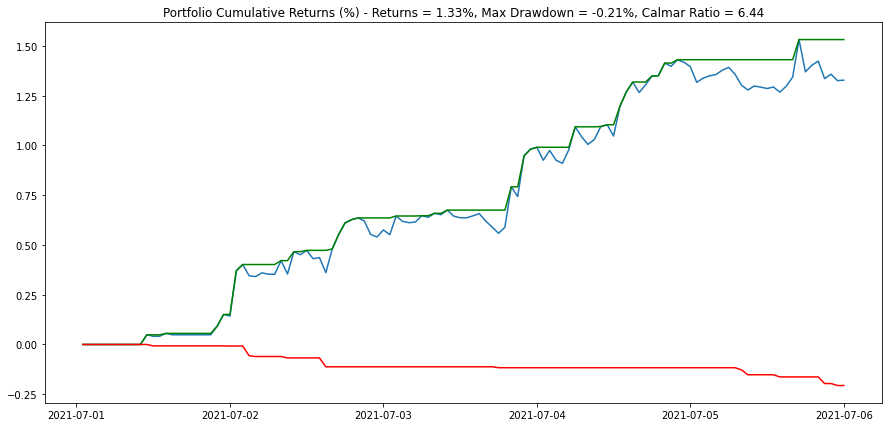

In [190]:
# Backtest
backtest_params = {
    'start_date': datetime.fromisoformat('2021-06-01 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-09-01 00:00:00+00:00'),
    'formation_period_days': 30,
    'trading_period_days': 5,
    'taker_fee': 0.0007,
    'entry_multiple': 1,
    'stop_multiple': 2,
    'half_life_multiple': 1,
    'nbr_max_pairs': 10,
    'display_cluster': False
}

res = backtest_mean_reversion_portfolio(prices_df, backtest_params, True)
res['pairs']

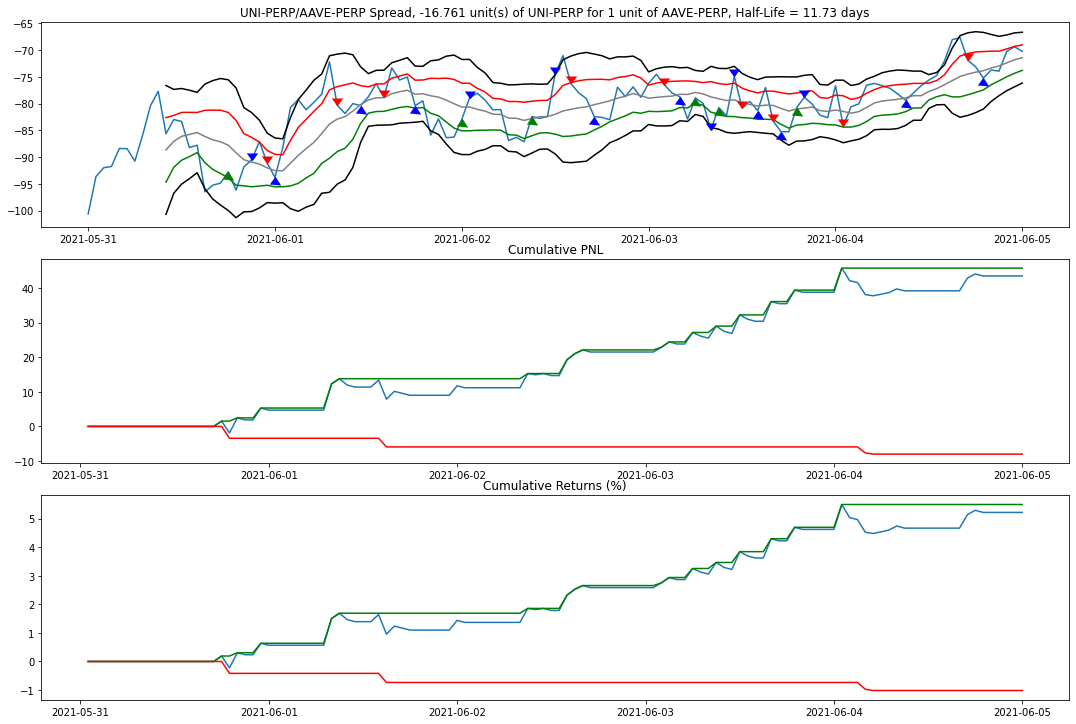

In [191]:
backtest_params_single_pair = {
    'start_date': datetime.fromisoformat('2021-05-01 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-09-01 00:00:00+00:00'),
    'formation_period_days': 30,
    'trading_period_days': 5,
    'taker_fee': 0.0007,
    'entry_multiple': 1,
    'stop_multiple': 2,
    'half_life_multiple': 1,
    'nbr_max_pairs': 10
}

res = backtest_mean_reversion_single_pair(res['pairs'].iloc[0], prices_df, backtest_params_single_pair)